# Processing Monthly and Annual Averages for DuPontavice Bottom Temperature Product

In [1]:
import os
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Set local location to dupontavice data
os.chdir('../..')
bt_path = "Data/raw/"

In [2]:
# load with xarray
bt_daily = xr.open_dataset(f"{bt_path}bottom_temp_combined_product_1959_2020.nc")
bt_daily = bt_daily.rename({"sea_water_temperature_at_sea_floor" : "bot_temp"})
bt_daily

<xarray.Dataset>
Dimensions:    (day: 366, latitude: 103, longitude: 123, year: 62)
Coordinates:
  * day        (day) float64 1.0 2.0 3.0 4.0 5.0 ... 363.0 364.0 365.0 366.0
  * latitude   (latitude) float64 35.92 36.0 36.08 36.17 ... 44.25 44.33 44.42
  * longitude  (longitude) float64 -75.92 -75.83 -75.75 ... -65.92 -65.83 -65.75
  * year       (year) float64 1.959e+03 1.96e+03 ... 2.019e+03 2.02e+03
Data variables:
    bot_temp   (year, day, latitude, longitude) float32 ...
Attributes: (12/34)
    title:                           Bottom temperature product for the north...
    summary:                         Two ocean products are combined, a regio...
    keywords:                        bottom temperature; northeast U.S. conti...
    source:                          GLORYS12V1 and ROM-NWA
    source_data_url:                 GLORYS12V1 = https://data.marine.coperni...
    source_data_doi:                 GLORYS12V1 = https://doi.org/10.48670/mo...
    ...                              ...
    time_coverage_resolution:        24:00:00
    date_created:                    2023-04-26T10:12:00
    date_modified:                   2023-04-26T10:12:00
    date_issued:                     2023-04-26T10:12:00
    date_metadata_modified:          2023-04-26T10:12:00
    NCO:                             netCDF Operators version 4.9.3-alpha02 (...

## Monthly Averages

In [17]:
# Create a single date dimension that will understand year and month for aggregating
# Make a date dimension that will understand year and month


# Use year and doy values from array
yvals = np.round(bt_daily.year.values).astype(np.int64)
doy_vals = bt_daily.day.values

# Create a new date coordinate array
dates = [pd.Timestamp(year=int(year), month=1, day=1) + pd.Timedelta(days=int(day)-1)
         for year in yvals for day in doy_vals]
dates = np.array(dates)
dates


array([Timestamp('1959-01-01 00:00:00'), Timestamp('1959-01-02 00:00:00'),
       Timestamp('1959-01-03 00:00:00'), ...,
       Timestamp('2020-12-29 00:00:00'), Timestamp('2020-12-30 00:00:00'),
       Timestamp('2020-12-31 00:00:00')], dtype=object)

In [23]:
# Reshape the dataset to have 'date' as a new dimension
# Reshape the data to fit the new dimensions (date, latitude, longitude)
lats = bt_daily.latitude.values
lons = bt_daily.longitude.values
reshaped_data = bt_daily.bot_temp.values.reshape(len(dates), len(lats), len(lons))
reshaped_data

# Create a new dataset with 'date', 'latitude', and 'longitude' dimensions
new_ds = xr.Dataset(
    {
        "bot_temp": (("time", "latitude", "longitude"), reshaped_data)
    },
    coords = {
        "time": dates,
        "latitude": lats,
        "longitude": lons
    }
)

# Display the new dataset
new_ds

<xarray.Dataset>
Dimensions:    (time: 22692, latitude: 103, longitude: 123)
Coordinates:
  * time       (time) datetime64[ns] 1959-01-01 1959-01-02 ... 2020-12-31
  * latitude   (latitude) float64 35.92 36.0 36.08 36.17 ... 44.25 44.33 44.42
  * longitude  (longitude) float64 -75.92 -75.83 -75.75 ... -65.92 -65.83 -65.75
Data variables:
    bot_temp   (time, latitude, longitude) float32 nan nan nan ... nan nan nan

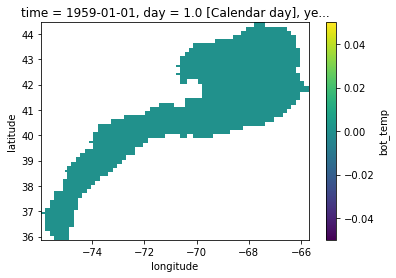

In [27]:
# Does it match up?
new_d1 = new_ds.bot_temp.isel(time = 0)

# To the original
old_d1 = bt_daily.bot_temp.isel(day = 0, year = 0)
(new_d1 - old_d1).plot()

## Resampling to Monthly

In [69]:
# Resampling to monthly


# Start with the new dataset that has time dimension
bt_new = new_ds

# Use resample to calculate monthly averages
monthly_avg = bt_new.resample(time='M').mean(keep_attrs = True)
monthly_avg

# Add year and month as separate coordinates for clarity
monthly_avg = monthly_avg.assign_coords(
    year=("time", monthly_avg.time.dt.year.values),
    month=("time", monthly_avg.time.dt.month.values))

# There we go
monthly_avg

<xarray.Dataset>
Dimensions:    (time: 744, latitude: 103, longitude: 123)
Coordinates:
  * latitude   (latitude) float64 35.92 36.0 36.08 36.17 ... 44.25 44.33 44.42
  * longitude  (longitude) float64 -75.92 -75.83 -75.75 ... -65.92 -65.83 -65.75
  * time       (time) datetime64[ns] 1959-01-31 1959-02-28 ... 2020-12-31
    year       (time) int64 1959 1959 1959 1959 1959 ... 2020 2020 2020 2020
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    bot_temp   (time, latitude, longitude) float32 nan nan nan ... nan nan nan

## Annual Average Bottom Temperature

In [70]:
# Do the same for annual data:
# Use resample to calculate monthly averages
annual_avg = bt_new.resample(time='Y').mean(keep_attrs = True)
annual_avg

# # Change datetime coordinate to year
# year_coords = annual_avg.time.dt.year.data
# annual_avg = annual_avg.assign_coords(year = year_coords)

# There we go
annual_avg#.isel(time = 0).bot_temp.plot()

<xarray.Dataset>
Dimensions:    (time: 62, latitude: 103, longitude: 123)
Coordinates:
  * latitude   (latitude) float64 35.92 36.0 36.08 36.17 ... 44.25 44.33 44.42
  * longitude  (longitude) float64 -75.92 -75.83 -75.75 ... -65.92 -65.83 -65.75
  * time       (time) datetime64[ns] 1959-12-31 1960-12-31 ... 2020-12-31
Data variables:
    bot_temp   (time, latitude, longitude) float32 nan nan nan ... nan nan nan

## Saving Monthly and Annual Averages

Export these to Box/Res_Data for others to use.

In [71]:
# Path to cloud storage
box_root = "/Users/akemberling/Library/CloudStorage/Box-Box/RES_Data/"

# Names for files
monthly_out_path = f'{box_root}Du_Pontavice_Combined_BT/monthly_bottom_temp_combined_product_1959_2020.nc'
annual_out_path = f'{box_root}Du_Pontavice_Combined_BT/annual_bottom_temp_combined_product_1959_2020.nc'
print(f"Out path set to: {monthly_out_path}")
# Confirm it can see into directory
#os.listdir(f"{box_root}Du_Pontavice_Combined_BT")
      
# # And save them with original variable name
monthly_avg.rename({"bot_temp" : "sea_water_temperature_at_sea_floor"}).to_netcdf(monthly_out_path)
annual_avg.rename({"bot_temp" : "sea_water_temperature_at_sea_floor"}).to_netcdf(annual_out_path)

Out path set to: /Users/akemberling/Library/CloudStorage/Box-Box/RES_Data/Du_Pontavice_Combined_BT/monthly_bottom_temp_combined_product_1959_2020.nc
